In [1]:
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(1, "./utils/")
import HH, Stimuli
from neuron import h
h.load_file("stdrun.hoc")
from neuron.units import mV, ms
import time

## Hyperparameters

In [60]:
ns = [n for n in range(3, 21)]
num_histories = 1000
excitatory_interval = 5
inhibitory_interval = 15

num_input_patterns = 10

out_dir = './data/nst_distribution_evolution/'

experiment_id = np.random.randint(100000000)

## load histories

In [5]:
histories_data_dir = './data/partial_history/'

In [6]:
histories_sets = {
    'base': np.load(f'{histories_data_dir}histories_base.npy'),
    'lw': np.load(f'{histories_data_dir}histories_lw.npy'),
    'lt': np.load(f'{histories_data_dir}histories_lt.npy'),
    'lwlt': np.load(f'{histories_data_dir}histories_lwlt.npy'),
    'burst': np.load(f'{histories_data_dir}histories_burst.npy')
}

## Generate Stimuli

In [8]:
stimuli = {}

for i in range(num_input_patterns):
     stimuli[i] = Stimuli.excitatory_and_inhibitory_n(excitatory_interval, inhibitory_interval, max(ns))

In [62]:
with open(f'{out_dir}/stimuli_{experiment_id}.json', "w") as fout:
    json.dump(stimuli, fout)

## Run experiment

In [12]:
stim_scaffold = {
    'base': {
        'ex': Stimuli.PoissonStim(
            'ex_base', 'ex_base',
            interval=5,
            rev_potential=0,
            weight=0.0002,
            tau=2,
            seed='na'
        ),
        'in': Stimuli.PoissonStim(
            'in_base', 'in_base',
            interval=15,
            rev_potential=-80,
            weight=0.0005,
            tau=6,
            seed='na'
        )
    },
    'lw': {
        'ex': Stimuli.PoissonStim(
            'ex_lw', 'ex_lw',
            interval=5,
            rev_potential=0,
            weight=0.00015,
            tau=2,
            seed='na'
        ),
        'in': Stimuli.PoissonStim(
            'in_lw', 'in_lw',
            interval=15,
            rev_potential=-80,
            weight=0.0002,
            tau=6,
            seed='na'
        )
    },
    'lt': {
        'ex': Stimuli.PoissonStim(
            'ex_lt', 'ex_lt',
            interval=5,
            rev_potential=0,
            weight=0.0002,
            tau=10,
            seed='na'
        ),
        'in': Stimuli.PoissonStim(
            'in_lt', 'in_lt',
            interval=15,
            rev_potential=-80,
            weight=0.0005,
            tau=40,
            seed='na'
        )
    },
    'lwlt': {
        'ex': Stimuli.PoissonStim(
            'ex_lwlt', 'ex_lwlt',
            interval=5,
            rev_potential=0,
            weight=0.00015,
            tau=10,
            seed='na'
        ),
        'in': Stimuli.PoissonStim(
            'in_lwlt', 'in_lwlt',
            interval=15,
            rev_potential=-80,
            weight=0.0002,
            tau=40,
            seed='na'
        )
    },
    'burst': {
        'ex': Stimuli.PoissonStim(
            'ex_burst', 'ex_burst',
            interval=5,
            rev_potential=0,
            weight=0.0001,
            tau=40,
            seed='na'
        ),
        'in': Stimuli.PoissonStim(
            'in_burst', 'in_burst',
            interval=15,
            rev_potential=-80,
            weight=0.0005,
            tau=20,
            seed='na'
        )
    }
}

In [56]:
for stim_type in stim_scaffold:
    for stim_pattern_ind in range(num_input_patterns):
        print(" "*(len(stim_type) + len(str(stim_pattern_ind)) + 2) + '_' * len(ns))
        print(f'{stim_type} {stim_pattern_ind}:', end='')
        stim_pattern = stimuli[stim_pattern_ind]
        results = {n:[] for n in ns}
        for n in ns:
            _stims = stim_pattern[-n:]

            # run a bunch of cells in parallel
            stim_min = min([t for stim_type, t in _stims])


            _e_times = [t - stim_min for stim_type, t in _stims if stim_type == 'e']
            _i_times = [t - stim_min for stim_type, t in _stims if stim_type == 'i']

            stim_duration = max(_e_times + _i_times) # total duration of the stimuli

            cells = {}
            fInitializeHandlers = []

            for history_ind in range(num_histories):
                history = histories_sets[stim_type][:, history_ind]
                cells[history_ind] = HH.HH()
                stim_scaffold[stim_type]['ex'].stim_times = _e_times
                stim_scaffold[stim_type]['in'].stim_times = _i_times
                cells[history_ind].add_custom_stimulus(stim_scaffold[stim_type]['ex'])
                cells[history_ind].add_custom_stimulus(stim_scaffold[stim_type]['in'])
                cells[history_ind].sim_init(
                    v0 = history[0],
                    m0 = history[1],
                    h0 = history[2],
                    n0 = history[3]
                )
                fInitializeHandlers.append(h.FInitializeHandler(cells[history_ind].do_sim_init))

            h.finitialize(-65)
            h.continuerun(stim_duration + 20 * ms)

            for history_ind in range(num_histories):
                nsts = [spike - stim_duration for spike in list(cells[history_ind].spike_times)]
                nsts = [nst for nst in nsts if nst > 0]
                if len(nsts) < 1:
                    results[n].append(np.nan)
                else:
                    results[n].append(min(nsts))
            print(']',end='')
        with open(f'{out_dir}results/{stim_type}_{experiment_id}_{stim_pattern_ind}.json', "w") as fout:
            json.dump(results, fout)
        print()

       __________________
base 0:]]]]]]]]]]]]]]]]]]
       __________________
base 1:]]]]]]]]]]]]]]]]]]
       __________________
base 2:]]]]]]]]]]]]]]]]]]
       __________________
base 3:]]]]]]]]]]]]]]]]]

KeyboardInterrupt: 

In [59]:
np.random.randint(1000000)

746002

## analysis

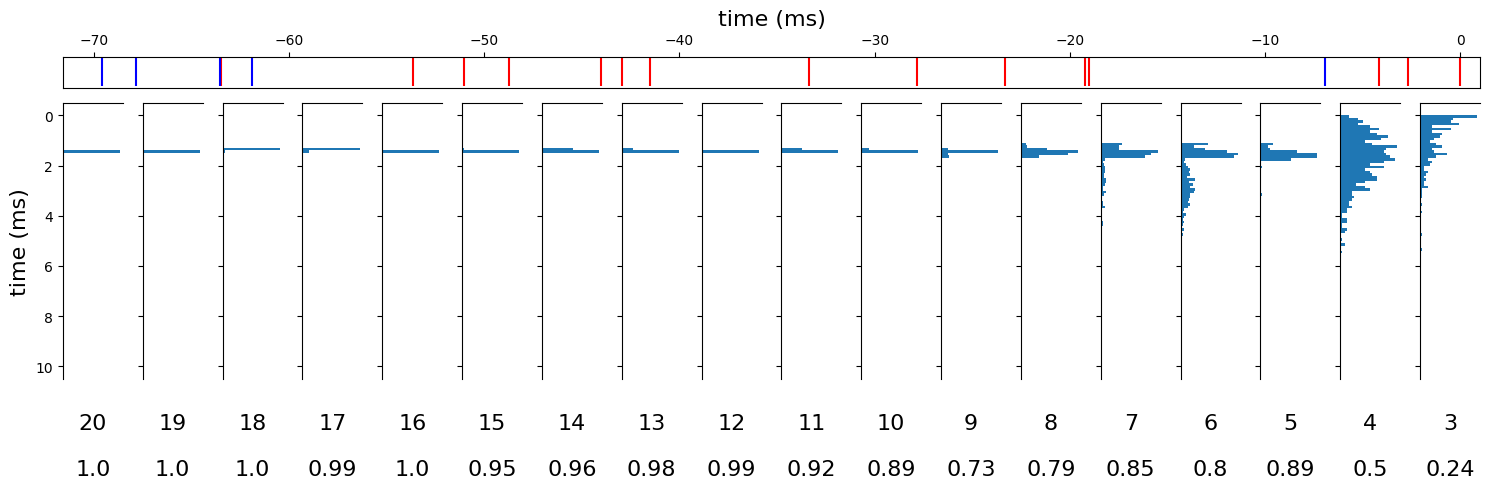

In [45]:
hist_axes = [str(ind) for ind in ns]
step = 0.1
bins = np.arange(0, 10+step, step)

hist_axes.reverse()

max_time = max([t for event_type, t in stim_pattern])

gs_kw = dict( height_ratios=[.1, .9])
fig, axd = plt.subplot_mosaic(
    [['raster']*len(ns), hist_axes],
    gridspec_kw=gs_kw, figsize=(15, 5),
    )

# raster
# recenter input times
axd['raster'].vlines([t - max_time for event_type, t in stim_pattern if event_type == 'e'], 0, 1, colors='red')
axd['raster'].vlines([t - max_time for event_type, t in stim_pattern if event_type == 'i'], 0, 1, colors='blue')

axd['raster'].xaxis.tick_top()
axd['raster'].set_yticks([])
axd['raster'].set_xlim(- max_time -2, 1)
axd['raster'].set_title('time (ms)', fontsize=16)

# histograms
for n in ns:
    axd[str(n)].hist(results[n], bins=bins, orientation="horizontal")
    spike_freq = round(np.sum(~np.isnan(results[n])) / len(results[n]) , 2)
    axd[str(n)].set_xlabel('\n'+str(n)+'\n\n'+str(spike_freq), fontsize=16)
    # aesthetics
    axd[str(n)].spines['bottom'].set_visible(False)
    axd[str(n)].spines['right'].set_visible(False)
    axd[str(n)].invert_yaxis()
    axd[str(n)].set_xticks([])
    if n != max(ns):
        axd[str(n)].set_yticklabels([])
    else:
        axd[str(n)].set_ylabel('time (ms)', fontsize=16)

fig.tight_layout()
plt.show()

In [46]:
with open(f'{data_dir}results/'):
    results

{3: [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  0.02711093262563935,
  0.17711093262564148,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  1.1021109326256546,
  1.5271109326256607,
  nan,
  0.3771109326256443,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  0.8771109326256514,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  0.7021109326256489,
  nan,
  nan,
  nan,
  nan,
  nan,
  0.02711093262563935,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  0.17711093262564148,
  nan,
  nan,
  0.42711093262564503,
  nan,
  nan,
  1.977110932625667,
  1.1771109326256557,
  nan,
  nan,
  nan,
  nan,
  nan,
  0.9021109326256518,
  nan,
  1.0021109326256532,
  0.30211093262564326,
  nan,
  nan,
  nan,
  0.5521109326256468,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  0.77711093262565,
  nan,
  nan,
  1.1521109326256553,
  0.5771109326256472,
  0.3771109326256443,
  nan,
  nan,
  0.3271109326256436,
  nan,
  1.252